In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Pragati
[nltk_data]     Aggarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
data = pd.read_csv('Emails.csv')
data.head()

data.drop(columns=['label'], inplace=True)
data=data.iloc[:,1:]

print(data)

                                                   text  label_num
0     Subject: enron methanol ; meter # : 988291\r\n...          0
1     Subject: hpl nom for january 9 , 2001\r\n( see...          0
2     Subject: neon retreat\r\nho ho ho , we ' re ar...          0
3     Subject: photoshop , windows , office . cheap ...          1
4     Subject: re : indian springs\r\nthis deal is t...          0
...                                                 ...        ...
5166  Subject: put the 10 on the ft\r\nthe transport...          0
5167  Subject: 3 / 4 / 2000 and following noms\r\nhp...          0
5168  Subject: calpine daily gas nomination\r\n>\r\n...          0
5169  Subject: industrial worksheets for august 2000...          0
5170  Subject: important online banking alert\r\ndea...          1

[5171 rows x 2 columns]


In [14]:
data['text']= data['text'].apply(lambda s:s.replace("Subject",""))
print(data)

                                                   text  label_num
0     : enron methanol ; meter # : 988291\r\nthis is...          0
1     : hpl nom for january 9 , 2001\r\n( see attach...          0
2     : neon retreat\r\nho ho ho , we ' re around to...          0
3     : photoshop , windows , office . cheap . main ...          1
4     : re : indian springs\r\nthis deal is to book ...          0
...                                                 ...        ...
5166  : put the 10 on the ft\r\nthe transport volume...          0
5167  : 3 / 4 / 2000 and following noms\r\nhpl can '...          0
5168  : calpine daily gas nomination\r\n>\r\n>\r\nju...          0
5169  : industrial worksheets for august 2000 activi...          0
5170  : important online banking alert\r\ndear value...          1

[5171 rows x 2 columns]


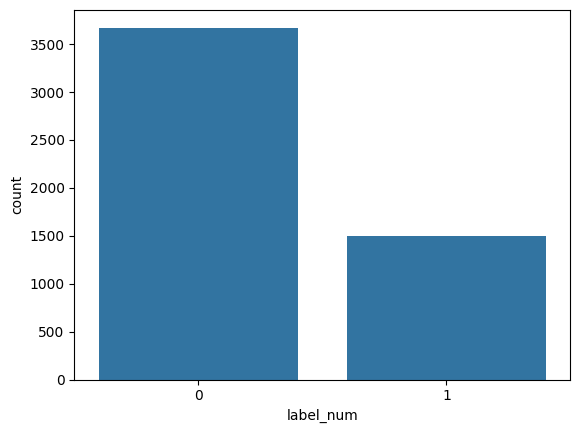

In [15]:
sns.countplot(x='label_num', data=data)
plt.show()

In [19]:
ham_msg = data[data.label_num == 0]
spam_msg = data[data.label_num == 1]
# print(spam_msg)

ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)
print(ham_msg)

                                                   text  label_num
2977  : conoco - big cowboy\r\ndarren :\r\ni ' m not...          0
3822  : feb 01 prod : sale to teco gas processing\r\...          0
2257  : california energy crisis\r\ncalifornia  , s...          0
2786  : re : nom / actual volume for april 23 rd\r\n...          0
4551  : eastrans nomination changes effective 8 / 2 ...          0
...                                                 ...        ...
2877  : fw : duke energy trading and marketing , l ....          0
3010  : re : greatwood gas\r\nthanks , kyle .\r\ngre...          0
1893  : tufco\r\nmy est . for tufco is the same as l...          0
1106  : mobil discrepancies\r\ndaren :\r\ni ' ll com...          0
4618  : cornhusker for sept\r\ncorrection : that sho...          0

[1499 rows x 2 columns]


Axes(0.125,0.11;0.775x0.77)


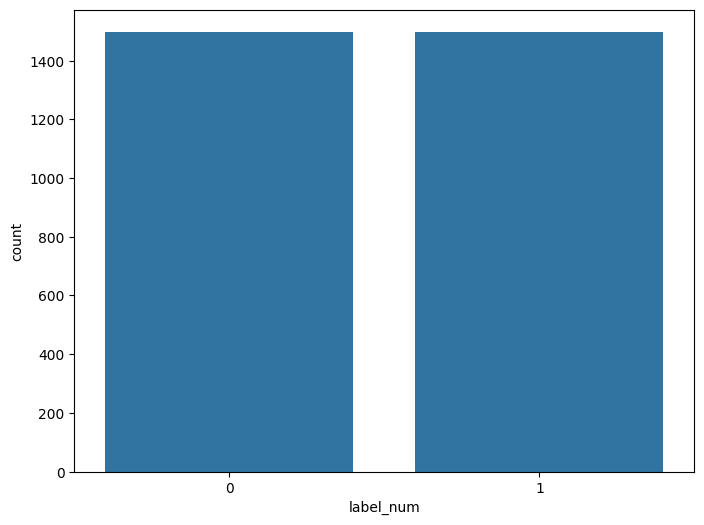

In [29]:
balanced_data= pd.concat((ham_msg,spam_msg)).reset_index(drop=True)
plt.figure(figsize=(8,6))
print(sns.countplot(data=balanced_data,x='label_num'))

In [25]:
punctuations_list = string.punctuation
print(punctuations_list)
punctuations_list= punctuations_list+"\r\n"

def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
print(balanced_data.head())

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
                                                text  label_num
0   conoco  big cowboydarren i  m not sure if you...          0
1   feb 01 prod  sale to teco gas processingsaled...          0
2   california energy crisiscalifornia   s power...          0
3   re  nom  actual volume for april 23 rdwe agre...          0
4   eastrans nomination changes effective 8  2  0...          0


In [26]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,label_num
0,conoco big cowboydarren sure help know else as...,0
1,feb 01 prod sale teco gas processingsaledeal 2...,0
2,california energy crisiscalifornia  power cri...,0
3,nom actual volume april 23 rdwe agree eileen p...,0
4,eastrans nomination changes effective 8 2 00pl...,0


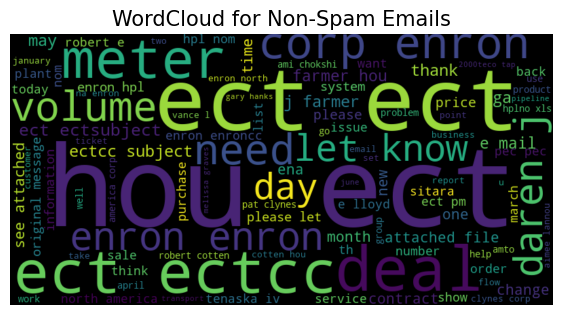

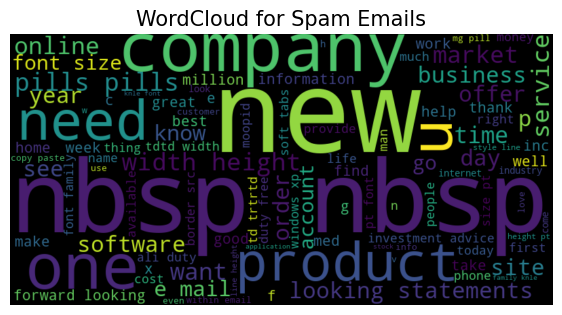

In [28]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label_num'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label_num'] == 1], typ='Spam')

In [34]:
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'], balanced_data['label_num'], test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)#generating train sequence
test_sequences = tokenizer.texts_to_sequences(test_X)#generating test sequence

#pad sequences to have the same length
max_len = 100  # Maximum sequence length, it will be generated based on the sentence
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

print(train_sequences)#the no.s represent total frequency of every word in the data
print("\n",test_sequences)



[[  421  2223   565 ...  4741     0     0]
 [  868  4742   673 ...     2  1480    20]
 [ 1867   108   298 ...     0     0     0]
 ...
 [  485    11  1313 ...  5731   112 45096]
 [   22   494     7 ...     0     0     0]
 [   18  2066    41 ...   573     2   249]]

 [[ 463  286   31 ...    0    0    0]
 [ 428 1967 5051 ...  456   20   69]
 [ 671  300  213 ...    0    0    0]
 ...
 [ 637  655    7 ...    0    0    0]
 [ 216  165 2224 ...    0    0    0]
 [ 545 1622 1979 ...    0    0    0]]


In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

In [43]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)


In [45]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 8.9448e-04 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss: 7.4156e-04 - val_accuracy: 1.0000 - val_loss: 3.9856e-04 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 1.0000 - loss: 3.7697e-04 - val_accuracy: 1.0000 - val_loss: 2.4751e-04 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 2.3788e-04 - val_accuracy: 1.0000 - val_loss: 1.7489e-04 - learning_rate: 0.0010


In [46]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.5908e-04
Test Loss : 0.0008944826549850404
Test Accuracy : 1.0


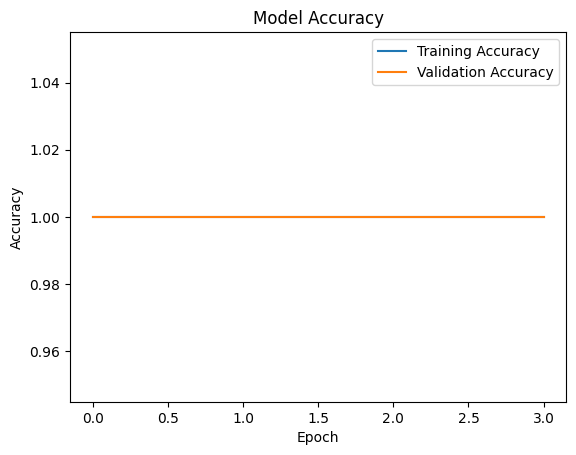

In [47]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()